In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gurobipy
gurobipy.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-21


<gurobi.Model Continuous instance Unnamed: 0 constrs, 0 vars, Parameter changes: Username=(user-defined)>

In [3]:
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [4]:
from gurobipy import *

In [5]:
import pypsa
import pandas as pd
from dataclasses import dataclass

In [6]:
full_demand = pd.read_csv("./data/demand_2025_scandinavia.csv", sep=";", index_col=1, parse_dates=True).groupby(pd.Grouper(key="climatic_year"))
full_wind_on_shore = pd.read_csv("./data/capa_factor_2025_scandinavia_onshore.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))
full_solar = pd.read_csv("./data/capa_factor_2025_scandinavia_solar.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))
full_wind_off_shore = pd.read_csv("./data/capa_factor_2025_scandinavia_offshore.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))




In [7]:
climatic_year = 2000
time_horizon_in_hours = 365 * 24

In [8]:
demand = full_demand.get_group(climatic_year)
solar = full_solar.get_group(climatic_year)
wind_on_shore = full_wind_on_shore.get_group(climatic_year)
wind_off_shore = full_wind_off_shore.get_group(climatic_year)

In [9]:
network = pypsa.Network(snapshots=demand.index[0:time_horizon_in_hours])

In [10]:
network.add("Bus", name="Scandinavia", x=15.255119, y=60.128161)
network.add("Bus", name="Curtailment", x=10, y=20)

In [11]:
@dataclass
class Carriers:
    Battery = 0
    Biomass = 230
    Coal = 760
    Gas = 370
    Oil = 406
    Hydrogen = 490
    Hydro = 24
    Nuclear = 12
    Pumped = 0
    Reservoir = 0
    Solar = 45
    Wind = 11

In [12]:
for name, co2_emission in Carriers().__dict__.items():
    network.add("Carrier", name=name, co2_emissions=co2_emission)

In [13]:
#???
coal_marginal_costs = 160
gas_marginal_costs = 120
oil_marginal_costs = 100
nuclear_marginal_costs = 10
hydro_marginal_costs = 0
wind_marginal_costs = 0
solar_marginal_costs = 0
biomass_marginal_costs = 0


#coal_marginal_costs = 128 / 7 / 0.37 
#gas_marginal_costs = 2.65 * 26.4 * 0.75 / 14.9 / 0.5
#oil_marginal_costs = 73 * 0.119 / 12.5 / 0.40

In [14]:
generators = [
    {"name": "Coal", "carrier": "Coal", "p_nom": 2112, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": coal_marginal_costs, "efficiency": 0.37, "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "Gas", "carrier": "Gas", "p_nom": 2640, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": gas_marginal_costs, "efficiency": 0.5,
     "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "Oil", "carrier": "Oil", "p_nom": 0, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": oil_marginal_costs, "efficiency": 0.4,
     "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "BioEnergies", "carrier": "BioEnergies", "p_nom":2540, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": biomass_marginal_costs, "efficiency": 0.5, 
     "committable": True, "min_up_time": 1, "min_down_time": 1},
    {"name": "Hydroelectric", "carrier":"Hydro", "p_nom": 38561, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": hydro_marginal_costs, "efficiency": 1, "committable": True,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Wind", "carrier": "Wind", "p_nom": 22783, "p_min_pu":1, "p_max_pu": 1, "marginal_cost": wind_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Nuclear", "carrier": "Nuclear", "p_nom": 9727, "p_min_pu":1, "p_max_pu": 1, "marginal_cost": nuclear_marginal_costs, "efficiency":1, "committable": True,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Solar", "carrier": "Solar", "p_nom": 889, "p_min_pu":1, "p_max_pu": 1, "marginal_cost": solar_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Failure", "carrier": "Failure", "p_nom": 100000, "p_min_pu":1, "p_max_pu": 1, "marginal_cost": 100000, "efficiency":1, "committable": True,
     "min_up_time": 1, "min_down_time": 1},
    #{"name": "Curtailment", "carrier": "Curtailment", "p_nom": 100000, "p_min_pu":1, "p_max_pu": 1, "marginal_cost": 0, "efficiency":1, "committable": True,
     #"min_up_time": 1, "min_down_time": 1},
]

storage_units = []

links = []

In [15]:
for generator in generators:
    network.add("Generator", bus="Scandinavia", **generator,)

In [16]:
generators

[{'name': 'Coal',
  'carrier': 'Coal',
  'p_nom': 2112,
  'p_min_pu': 0,
  'p_max_pu': 1,
  'marginal_cost': 160,
  'efficiency': 0.37,
  'committable': True,
  'min_up_time': 1,
  'min_down_time': 1},
 {'name': 'Gas',
  'carrier': 'Gas',
  'p_nom': 2640,
  'p_min_pu': 0,
  'p_max_pu': 1,
  'marginal_cost': 120,
  'efficiency': 0.5,
  'committable': True,
  'min_up_time': 1,
  'min_down_time': 1},
 {'name': 'Oil',
  'carrier': 'Oil',
  'p_nom': 0,
  'p_min_pu': 0,
  'p_max_pu': 1,
  'marginal_cost': 100,
  'efficiency': 0.4,
  'committable': True,
  'min_up_time': 1,
  'min_down_time': 1},
 {'name': 'BioEnergies',
  'carrier': 'BioEnergies',
  'p_nom': 2540,
  'p_min_pu': 0,
  'p_max_pu': 1,
  'marginal_cost': 0,
  'efficiency': 0.5,
  'committable': True,
  'min_up_time': 1,
  'min_down_time': 1},
 {'name': 'Hydroelectric',
  'carrier': 'Hydro',
  'p_nom': 38561,
  'p_min_pu': 0,
  'p_max_pu': 1,
  'marginal_cost': 0,
  'efficiency': 1,
  'committable': True,
  'min_up_time': 1,
  'mi

In [17]:
#'carrier', "AC" ?? 

loads = [
    {"name": "Scandinavia-load", "bus": "Scandinavia", "carrier": "AC","p_set": demand[0:time_horizon_in_hours]["value"].values},
]   

In [18]:
for load in loads:
    network.add("Load", **load)

In [19]:
network

PyPSA Network
Components:
 - Bus: 2
 - Generator: 9
 - Load: 1
Snapshots: 8760

In [20]:
result = network.optimize(solver_name="gurobi")
print(result)   

{'Curtailment'}
{'Curtailment'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2024-11-21


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2024-11-21
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|█████████████████████████████████████████| 3/3 [00:00<00:00, 23.17it/s]
INFO:linopy.io: Writing time: 2.93s


Read LP format model from file /private/var/folders/ms/4_rjwj4n1h1gg3k7zdvmsv5m0000gn/T/linopy-problem-3qd25xdw.lp


INFO:gurobipy.gurobipy:Read LP format model from file /private/var/folders/ms/4_rjwj4n1h1gg3k7zdvmsv5m0000gn/T/linopy-problem-3qd25xdw.lp


Reading time = 0.94 seconds


INFO:gurobipy.gurobipy:Reading time = 0.94 seconds


obj: 411706 rows, 262800 columns, 919758 nonzeros


INFO:gurobipy.gurobipy:obj: 411706 rows, 262800 columns, 919758 nonzeros


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])


INFO:gurobipy.gurobipy:Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])


INFO:gurobipy.gurobipy:


CPU model: Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz


INFO:gurobipy.gurobipy:CPU model: Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy.gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy.gurobipy:


Optimize a model with 411706 rows, 262800 columns and 919758 nonzeros


INFO:gurobipy.gurobipy:Optimize a model with 411706 rows, 262800 columns and 919758 nonzeros


Model fingerprint: 0xcc206a36


INFO:gurobipy.gurobipy:Model fingerprint: 0xcc206a36


Variable types: 78840 continuous, 183960 integer (183960 binary)


INFO:gurobipy.gurobipy:Variable types: 78840 continuous, 183960 integer (183960 binary)


Coefficient statistics:


INFO:gurobipy.gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+05]


INFO:gurobipy.gurobipy:  Matrix range     [1e+00, 1e+05]


  Objective range  [1e+01, 1e+05]


INFO:gurobipy.gurobipy:  Objective range  [1e+01, 1e+05]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy.gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 7e+04]


INFO:gurobipy.gurobipy:  RHS range        [1e+00, 7e+04]


Presolve removed 411705 rows and 262797 columns


INFO:gurobipy.gurobipy:Presolve removed 411705 rows and 262797 columns


Presolve time: 0.81s


INFO:gurobipy.gurobipy:Presolve time: 0.81s


Presolved: 1 rows, 3 columns, 3 nonzeros


INFO:gurobipy.gurobipy:Presolved: 1 rows, 3 columns, 3 nonzeros


Variable types: 2 continuous, 1 integer (1 binary)


INFO:gurobipy.gurobipy:Variable types: 2 continuous, 1 integer (1 binary)


Found heuristic solution: objective 1.985029e+07


INFO:gurobipy.gurobipy:Found heuristic solution: objective 1.985029e+07


INFO:gurobipy.gurobipy:


Explored 0 nodes (0 simplex iterations) in 1.10 seconds (0.79 work units)


INFO:gurobipy.gurobipy:Explored 0 nodes (0 simplex iterations) in 1.10 seconds (0.79 work units)


Thread count was 8 (of 8 available processors)


INFO:gurobipy.gurobipy:Thread count was 8 (of 8 available processors)


INFO:gurobipy.gurobipy:


Solution count 1: 1.98503e+07 


INFO:gurobipy.gurobipy:Solution count 1: 1.98503e+07 


INFO:gurobipy.gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy.gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 1.985029120000e+07, best bound 1.985029120000e+07, gap 0.0000%


INFO:gurobipy.gurobipy:Best objective 1.985029120000e+07, best bound 1.985029120000e+07, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 262800 primals, 0 duals
Objective: 1.99e+07
Solver model: available
Solver message: 2



('ok', 'optimal')


<Axes: xlabel='Generator', ylabel='GW'>

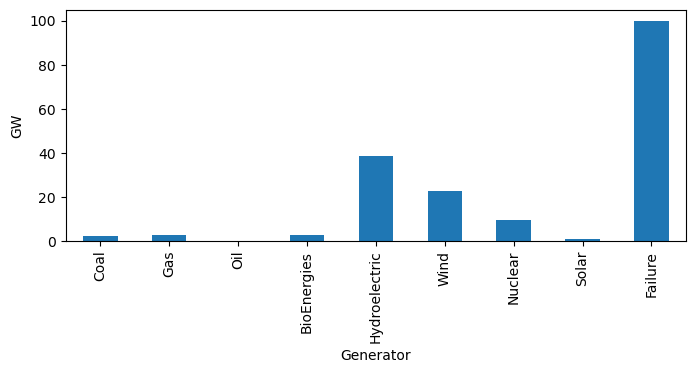

In [21]:
network.generators.p_nom_opt.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))

<Axes: xlabel='snapshot', ylabel='GW'>

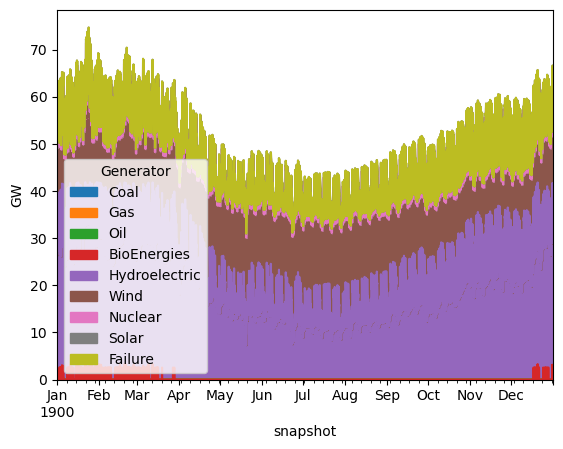

In [22]:
network.generators_t.p.div(1e3).plot.area(subplots=False, ylabel="GW")

In [23]:
network.generators_t

{'p_min_pu': Empty DataFrame
 Columns: []
 Index: [1900-01-01 00:00:00, 1900-01-01 01:00:00, 1900-01-01 02:00:00, 1900-01-01 03:00:00, 1900-01-01 04:00:00, 1900-01-01 05:00:00, 1900-01-01 06:00:00, 1900-01-01 07:00:00, 1900-01-01 08:00:00, 1900-01-01 09:00:00, 1900-01-01 10:00:00, 1900-01-01 11:00:00, 1900-01-01 12:00:00, 1900-01-01 13:00:00, 1900-01-01 14:00:00, 1900-01-01 15:00:00, 1900-01-01 16:00:00, 1900-01-01 17:00:00, 1900-01-01 18:00:00, 1900-01-01 19:00:00, 1900-01-01 20:00:00, 1900-01-01 21:00:00, 1900-01-01 22:00:00, 1900-01-01 23:00:00, 1900-01-02 00:00:00, 1900-01-02 01:00:00, 1900-01-02 02:00:00, 1900-01-02 03:00:00, 1900-01-02 04:00:00, 1900-01-02 05:00:00, 1900-01-02 06:00:00, 1900-01-02 07:00:00, 1900-01-02 08:00:00, 1900-01-02 09:00:00, 1900-01-02 10:00:00, 1900-01-02 11:00:00, 1900-01-02 12:00:00, 1900-01-02 13:00:00, 1900-01-02 14:00:00, 1900-01-02 15:00:00, 1900-01-02 16:00:00, 1900-01-02 17:00:00, 1900-01-02 18:00:00, 1900-01-02 19:00:00, 1900-01-02 20:00:00, 1900